# **Proyecto IA**

Juan David Cetina, Mariana Salas, Santiago Sabogal

## **1. Introducción**

En este proyecto se desarrolló, entrenó y evaluó un agente para el juego de Connect4 utilizando técnicas de aprendizaje por refuerzo. El objetivo principal fue construir una política capaz de tomar decisiones racionales a partir de la experiencia, empleando una Q-table aprendida mediante Q-learning tabular. Para ello, se implementó un entorno de juego completo y se diseñó un proceso de entrenamiento donde el agente juega 12,000 partidas contra un oponente heurístico. Durante este proceso, el agente aplica una estrategia UCB para equilibrar exploración y explotación, actualiza sus Q-values después de cada episodio y genera un archivo de modelo (*connect4_model.json*) que recoge el conocimiento adquirido.

Posteriormente, se integró esta Q-table en una policy final que combina tres elementos: búsqueda táctica de victorias y bloqueos inmediatos, consulta de los valores aprendidos, y una heurística basada en la centralidad del tablero para resolver estados no vistos. Asimismo, se generaron visualizaciones y métricas que permiten evaluar la evolución del agente, como curvas de recompensa, longitudes de partida, tasas de victoria frente al oponente heurístico y estadísticas completas de visitas y Q-values. Finalmente, el modelo entrenado fue utilizado para validar que la policy se vuelve progresivamente más racional y consistente, mostrando un comportamiento coherente con la dinámica del aprendizaje reforzado.

## **2. Metodología**

La metodología aplicada en este proyecto integra conceptos teóricos de toma de decisiones secuenciales, procesos de decisión de Markov y aprendizaje por refuerzo. El objetivo es desarrollar un agente para Connect4 que combine aprendizaje tabular con heurísticas tácticas para lograr un comportamiento útil y competitivo.

### **2.1. Propuestas iniciales**

#### **2.1.1. Agente heurístico**

Inicialmente, se hizo un agente heurístico en *policy_heuristica.py*, utiliza búsqueda minimax con poda alfa–beta y una evaluación heurística del tablero en lugar de MCTS. A partir del tablero actual, el agente identifica primero de quién es el turno y genera las columnas legales. Luego, aplica dos tácticas inmediatas, si existe una jugada ganadora la ejecuta, y si el rival puede ganar en una jugada, la bloquea. 

Cuando no hay táctica directa, se explora el árbol de juego hasta una profundidad fija usando minimax. Los nodos donde juega el agente intentan maximizar una función de evaluación, y los nodos del rival intentan minimizarla, mientras la poda alfa–beta descarta ramas que no pueden mejorar el resultado. La evaluación heurística recorre todas las “ventanas” posibles de 4 celdas (horizontales, verticales y diagonales) y asigna puntuaciones en función de alineaciones prometedoras del agente y amenazas del oponente. También, da un peso extra al control de la columna central. Entonces, los estados terminales se refuerzan con valores muy altos (victoria) o muy bajos (derrota), de forma que la búsqueda prioriza líneas que llevan a ganar y evita las que llevan a perder.

Esta fue la entrega del avance. Sin embargo, en la retroalimentación se explicó que los movimientos predeterminadas, pese a no estar mal y mostrar un buen rendimiento, siguen siendo principalmente un baseline. No hay aprendizaje ni verdadera racionalidad, son solo reglas específicas de juego con cierta profundidad limitada en la anticipación de decisiones futuras.

#### **2.1.2. Agente Monte Carlo Tree Search**

Siguendo las recomendaciones del profesor, se cambió el enfoque heurístico a uno de aprendizaje. En este, se tiene un agente para Connect4 llamado *MctsUcbPolicy* que decide cada jugada combinando búsqueda Monte Carlo Tree Search (MCTS) con la regla de selección UCB1 y una tabla de valores previa aprendida por self-play. En cada llamada a act, el agente primero aplica una táctica inmediata, si puede ganar en una jugada lo hace, y si el rival puede ganar en una jugada, bloquea esa amenaza. Si ninguna de estas condiciones aplica, se construye un árbol de búsqueda a partir del estado actual y se ejecuta un número fijo de simulaciones. En cada simulación se realiza el ciclo de MCTS (selección mediante UCB, expansión de nodos nuevos, simulación con una política ligera sesgada al centro del tablero y retropropagación de las recompensas). Además, se incorpora una tabla *values.json* donde se guardan valores aproximados V(s) obtenidos en el entrenamiento, que se utilizan como prior suave inicializando algunos nodos con visitas y recompensas virtuales. Entonces, el árbol se guía hacia estados que ya han demostrado ser prometedores. Al finalizar las simulaciones, el agente selecciona como acción final la columna asociada al hijo de la raíz con mayor número de visitas, favoreciendo en caso de empate a la columna central.

Sin embargo, pese a que fue entrenado miles de veces, no lograba pasar la simulación en Gradescope para ganarle a agentes aleatorios, así empezará como el jugador rojo o siendo el jugador amarillo.

Este agente puede encontrarse en *policy_mcts.py*.

#### **2.1.3. Agente con política de entrenamiento ε-Greedy**

Teniendo en cuenta lo mencionado previamente, se hace un agente con aprendizaje por refuerzo tabular para Connect4. Se tiene la policy *CetinaSalasSabogal* y un código de entrenamiento Q-learning contra un oponente heurístico (*train_heuristic.py*). La policy decide su jugada en tres escenarios. Primero, busca una victoria inmediata simulando cada columna disponible. Luego, intenta bloquear una posible victoria del rival en el siguiente turno y, si ninguna de esas tácticas aplica, consulta una Q-table aprendida, cargada desde *connect4_model.json* para elegir la acción legal con mayor valor Q. Entonces, si el estado no está en la tabla, recurre a una heurística fija que prioriza la columna central y las cercanas al centro. El script de entrenamiento, por su parte, entrena esa Q-table jugando miles de episodios contra un oponente, que también sabe ganar y bloquear en una jugada y prefiere el centro con la finalidad de competir contra un oponente más fuerte que uno random para el torneo. Este usa Q-learning con política ε-greedy (explora al inicio y se va volviendo más greedy con el tiempo), actualizando Q(s,a) al final de cada partida.

Este demuestra una curva de aprendizaje y logra pasar la prueba de Gradescope. Sin embargo, no fue escogida como la propuesta final debido a que presenta un desempeño menor a la seleccionada.

### **2.2. MDP**

Para el trabajo final, el juego Conenect4 se formuló como un Proceso de Decisión de Markov (MDP):

- **Estados \( S \):** Todas las configuraciones del tablero de 6 X 7, junto con el jugador al que le corresponde mover.
- **Acciones \( A \):** Columnas legales donde puede colocarse una ficha.
- **Transiciones \( P(s'| s, a) \):** Deterministas, porque una jugada siempre produce el mismo estado.
- **Recompensas \( r(s) \):**
  - \( +1 \) si el agente gana.
  - \( -1 \) si pierde.
  - \( 0 \) en empates.
- **Factor de descuento:** 0.95.

A continuación, se muestran fórmulas importantes a tener en cuenta.

$$
v^\pi(s) = \mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t \, r(S_t)\right]
$$

$$
q^\pi(s,a) = r(s) + \gamma \sum_{s'} P(s' \mid s,a)\, v^\pi(s')
$$

### **2.3. Política final**

La política final implementada en *CetinaSalasSabogal*, en *policy.py*, combina dos componentes principales:  
* **Heurística táctica**: Diseñada para detectar oportunidades de victoria y amenazas inmediatas. 
* **Q-table:** Aprendida durante el entrenamiento para seleccionar acciones con base en los valores Q almacenados.  

Este enfoque sigue el esquema de General Policy Iteration (GPI), ya que la política mejora mediante valores aprendidos, pero recurre a reglas tácticas cuando no posee información suficiente para un estado. Antes de cada partida, el método *mount()* intenta cargar, si existe, el archivo con el aprendizaje: *connect4_model.json*. Si el archivo no existe, contiene errores o está vacío, la Q-table se inicializa y la política opera únicamente con heurística.

Cuando sí existe información para el estado actual, la política selecciona:

$$
\pi(s) = \arg\max_{a \in A(s)} Q(s,a)
$$

El proceso es:

1. Codificar el estado con *codificar_posicion(tablero)*.  
2. Recuperar *self._q[estado]* si existe.  
3. Filtrar solo las acciones legales.  
4. Elegir la columna con mayor Q-valor.

Cuando no hay Q-valores útiles para el estado actual, la policy usa una heurística determinista compuesta por tres pasos:

* Buscar victoria inmediata, donde para cada columna legal se simula la jugada (*simular_caida*), se evalúa si produce un cuatro en línea usando *cuatro_en_linea()* y, si es victoria, juega esa columna inmediatamente.

* Bloquear victoria del rival, donde si el rival puede ganar en su próximo turno se identifica la columna peligrosa y se juega ahí para bloquear y evitar la derrota.

* Prioridad posicional, ya que si no hay ataques ni amenazas inmediatas, la política aplica esta prioridad de:
    1. Centro  
    2. Columnas adyacentes  
    3. Columnas intermedias  
    4. Esquinas

### **2.4. Política de entrenamiento**

Para el entrenamiento se implementa un esquema de aprendizaje por refuerzo en el que el agente aprende una tabla Q sobre el juego Conecta 4, con una estrategia de Upper Confidence Bound (UCB). El objetivo es equilibrar la explotación (usar las acciones con mejor valor estimado) y exploración (probar acciones de las que se tiene menos información). El entorno se modela como un MDP, como se mencionó anteriormente.

El entrenamiento utiliza un oponente determinista, que actúa como baseline y permite evaluar si el agente aprende a superar otras estrategias. Este oponente replica una política heurística de Connect4 basada en las siguientes reglas tácticas:

1. **Victoria inmediata:** Si existe una jugada ganadora en el turno actual, la ejecuta.
2. **Bloqueo inmediato:** Si el rival tiene una jugada ganadora en su siguiente turno, la bloquea.
3. **Prioridad posicional:** Prefiere jugar en columnas centrales (mejor control y más combinaciones posibles).
4. **Evitar derrotas inmediatas:** Identifica jugadas que le darían al rival una victoria automática y las evita cuando es posible.

Esta política garantiza que el agente se entrene contra un oponente consistente, lo que permite al algoritmo Q-learning aprender patrones de ataque y defensa más complejos.

Acerca del UCB, este se implementa mediante la fórmula:

$$
\text{UCB}(s,a) \;=\; Q(s,a) \;+\; c \sqrt{\frac{\ln N(s)}{N(s,a)}}
$$

- **\(Q(s,a)\):** Es el valor aprendido para la acción.
- **\(N(s,a)\):** Es el número de veces que se ha elegido la acción \(a\) en el estado \(s\).
- **\(N(s)\):** Es el número total de visitas a ese estado.
- **\(c\):** Es el parámetro de exploración (c = 1.4), siguiendo el recomendado en las diapositivas de clase.

Siguiendo esta estrategia, la política exploratoria del agente queda definida como:

$$
\pi_{\text{UCB}}(s) \;=\; 
\arg\max_{a \in A(s)} \left[ Q(s,a) + c \sqrt{\frac{\ln N(s)}{N(s,a)}} \right]
$$

Esta regla de decisión permite que el agente explore de forma inteligente y adaptativa, priorizando acciones poco investigadas. Los valores generados se van actualizando en la tabla.

## **3. Resultados**

### **3.1. Validación del agente**

Para la validación del agente, se tienen en cuenta diferentes métricas, como el porcentaje de jugadas ganadas, recompensas, longitud de las partidas y los valores de los Q-Values. Esto, con el fin de demuestrar un buen funcionamento de los componentes internos y comportamientos del agente. Además, se realizaron tres experimentos o curvas de aprendizaje para dar una idea más profunda de la estabilidad del rendimiento, comparando de manera visual y estadística, con la media y desviación estándar en la curva.

Primero, se importan las librerías a ser usadas en el notebook y se configuran las rutas a los JSON que tienen la información de las partidas.


In [248]:
# Importación de librerías

import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import Image

# Cargar los JSON

def cargar_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)
    
versiones = ["VS1_Mejorada", "VS2_Mejorada", "VS3_Mejorada"]

curva_paths = {}
selfplay_paths = {}
qstats_paths = {}

for vs in versiones:
    curva_files = glob.glob(os.path.join(vs, "curva_vs_heuristic_medium_ucb*.json"))
    selfplay_files = glob.glob(os.path.join(vs, "selfplay_qlearning_ucb_vs_heuristic_medium_*.json"))
    qstats_files = glob.glob(os.path.join(vs, "qstats_completo_ucb*.json"))

    if not curva_files:
        print(f"[WARN] No encontré curva en {vs}")
        continue
    if not selfplay_files:
        print(f"[WARN] No encontré selfplay en {vs}")
        continue

    if not qstats_files:
        print(f"[WARN] No encontré qstats en {vs}")
        continue

    curva_paths[vs] = sorted(curva_files)[0]
    selfplay_paths[vs] = sorted(selfplay_files)[0]
    qstats_paths[vs] = sorted(qstats_files)[0]

curva_paths, selfplay_paths, qstats_paths

({'VS1_Mejorada': 'VS1_Mejorada\\curva_vs_heuristic_medium_ucb_20251123_120409.json',
  'VS2_Mejorada': 'VS2_Mejorada\\curva_vs_heuristic_medium_ucb_20251123_125509.json',
  'VS3_Mejorada': 'VS3_Mejorada\\curva_vs_heuristic_medium_ucb_20251123_134735.json'},
 {'VS1_Mejorada': 'VS1_Mejorada\\selfplay_qlearning_ucb_vs_heuristic_medium_20251123_120409.json',
  'VS2_Mejorada': 'VS2_Mejorada\\selfplay_qlearning_ucb_vs_heuristic_medium_20251123_125509.json',
  'VS3_Mejorada': 'VS3_Mejorada\\selfplay_qlearning_ucb_vs_heuristic_medium_20251123_134735.json'},
 {'VS1_Mejorada': 'VS1_Mejorada\\qstats_completo_ucb_20251123_120409.json',
  'VS2_Mejorada': 'VS2_Mejorada\\qstats_completo_ucb_20251123_125509.json',
  'VS3_Mejorada': 'VS3_Mejorada\\qstats_completo_ucb_20251123_134735.json'})

Las curvas de aprendizaje obtenidas durante el entrenamiento muestran un patrón consistente en las tres versiones del agente evaluadas. En todos los casos se identifican claramente tres fases de aprendizaje. En la fase inicial, aproximadamente hasta los primeros 1000–1800 episodios, el winrate es prácticamente cero. Esto es esperable, dado que el agente parte sin valores Q informativos y UCB fomenta una exploración intensa. Esta etapa está dominada por decisiones casi aleatorias frente a un oponente heurístico determinista, lo que explica la elevada tasa de derrotas inicial.

Posteriormente, todas las versiones entran en una fase de estabilización donde el winrate se mantiene alrededor del 0.40–0.60. Este comportamiento indica que el agente ya es capaz de jugar de manera razonable, pero aún no ha descubierto estrategias robustas para superar de forma consistente al oponente.

Finalmente, todas las versiones experimentan un salto abrupto hacia un winrate del 100%, aunque a diferentes alturas del entrenamiento, alrededor del episodio 8000 y 11200. Este tipo de transición brusca es característico del aprendizaje basado en recompensas terminales y actualizaciones con UCB, donde ciertos estados y acciones clave sólo se valoran correctamente después de acumular suficientes visitas. El resultado final demuestra que las tres versiones del agente sí alcanzan una política altamente efectiva frente al oponente, y sirve como evidencia de que hay aprendizaje.

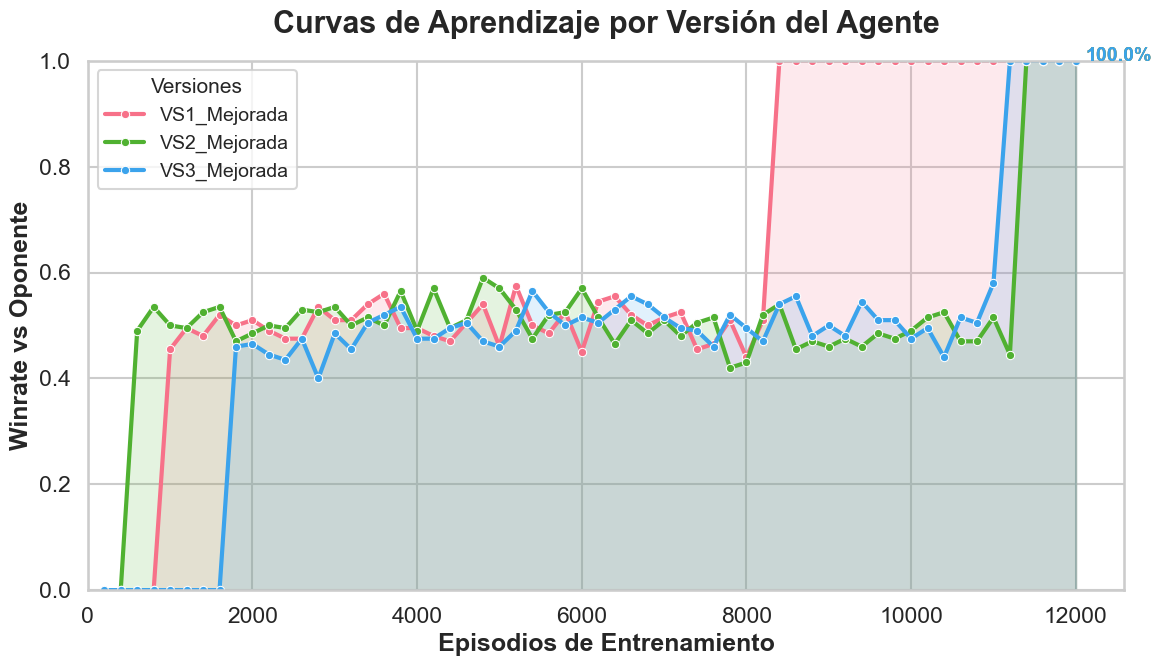

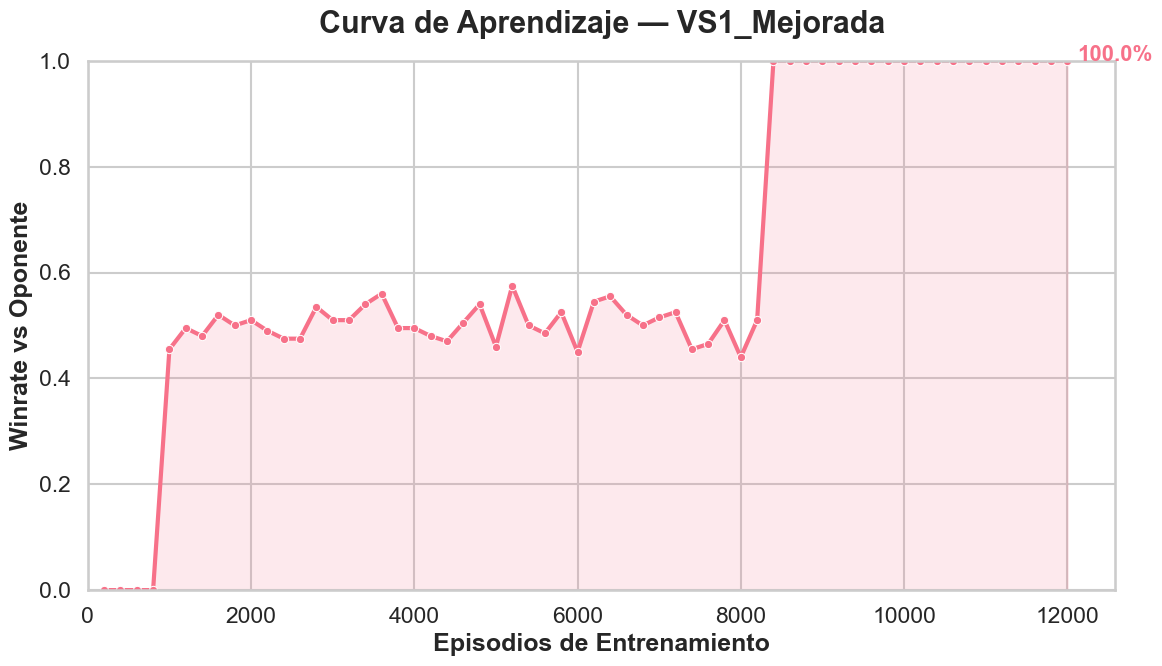

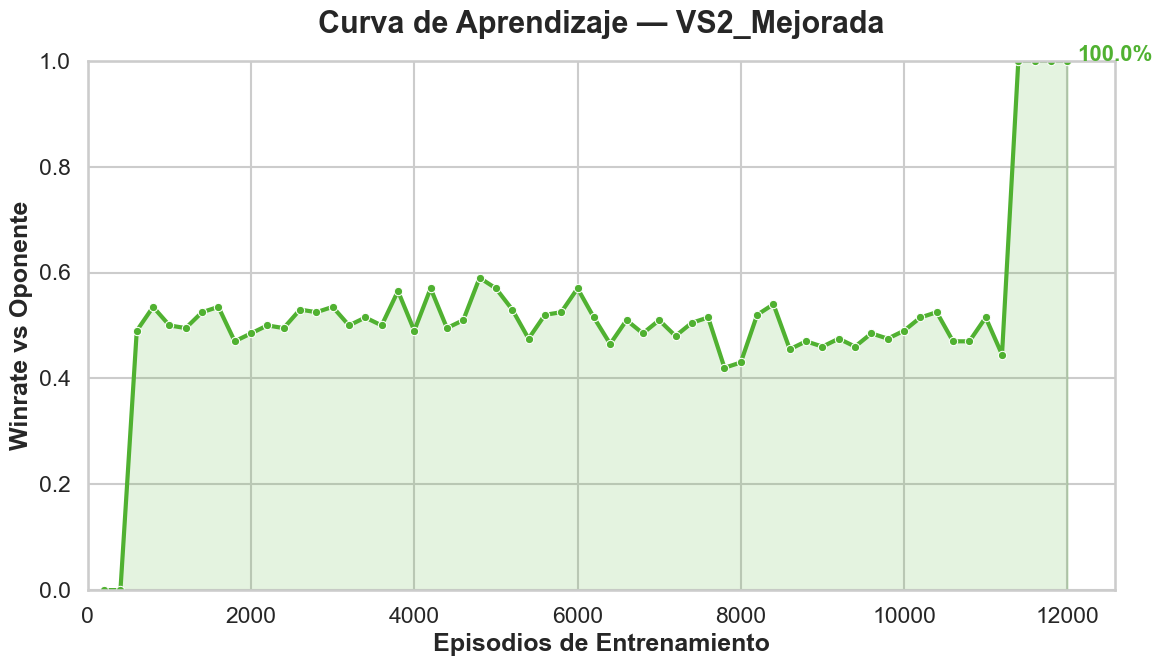

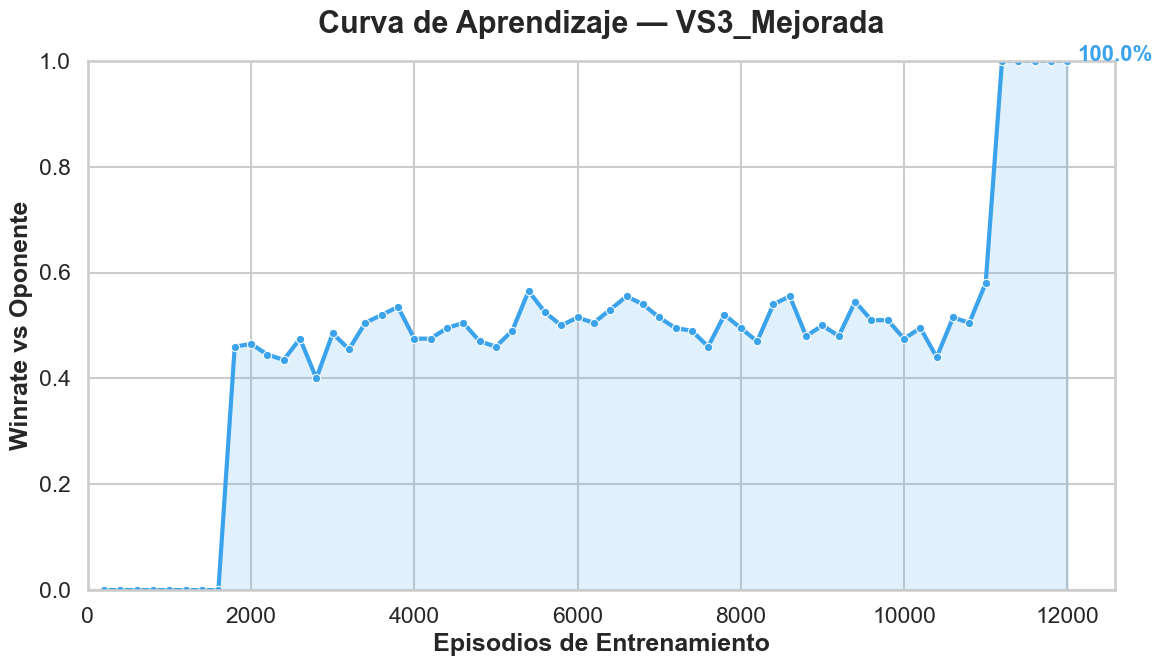

In [249]:
# Estilo elegante de seaborn
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(12, 7))

# Generar paleta automática bonita
palette = sns.color_palette("husl", n_colors=len(curva_paths))

for i, (vs, path) in enumerate(curva_paths.items()):
    data = cargar_json(path)
    hist = data["historial"]                  # lista de puntos {episodios, winrate, ...}

    episodios = np.array([p["episodios"] for p in hist])
    winrates  = np.array([p["winrate"] for p in hist])

    # Línea principal bonita
    sns.lineplot(
        x=episodios, 
        y=winrates, 
        linewidth=3, 
        color=palette[i],
        marker="o", 
        markersize=6,
        label=vs
    )

    # Relleno suave alrededor (tendencia)
    plt.fill_between(
        episodios,
        winrates,
        alpha=0.15,
        color=palette[i]
    )

    # Etiqueta en el último punto
    plt.text(
        episodios[-1] + episodios.max()*0.01,
        winrates[-1],
        f"{winrates[-1]*100:.1f}%",
        fontsize=14,
        fontweight="bold",
        color=palette[i]
    )

# Etiquetas y formato final
plt.title("Curvas de Aprendizaje por Versión del Agente", fontsize=22, pad=20, fontweight="bold")
plt.xlabel("Episodios de Entrenamiento", fontsize=18, fontweight="bold")
plt.ylabel("Winrate vs Oponente", fontsize=18, fontweight="bold")

plt.ylim(0.0, 1.0)
plt.xlim(left=0)

plt.legend(title="Versiones", fontsize=14, title_fontsize=15)
plt.tight_layout()
plt.show()

sns.set_theme(style="whitegrid", context="talk")

palette = sns.color_palette("husl", n_colors=len(curva_paths))

for i, (vs, path) in enumerate(curva_paths.items()):
    data = cargar_json(path)
    hist = data["historial"]
    episodios = np.array([p["episodios"] for p in hist])
    winrates  = np.array([p["winrate"] for p in hist])

    plt.figure(figsize=(12, 7))

    sns.lineplot(
        x=episodios,
        y=winrates,
        linewidth=3,
        color=palette[i],
        marker="o",
        markersize=6
    )

    plt.fill_between(
        episodios,
        winrates,
        alpha=0.15,
        color=palette[i]
    )

    plt.text(
        episodios[-1] + episodios.max()*0.01,
        winrates[-1],
        f"{winrates[-1]*100:.1f}%",
        fontsize=16,
        fontweight="bold",
        color=palette[i]
    )

    plt.title(f"Curva de Aprendizaje — {vs}", fontsize=22, pad=20, fontweight="bold")
    plt.xlabel("Episodios de Entrenamiento", fontsize=18, fontweight="bold")
    plt.ylabel("Winrate vs Oponente", fontsize=18, fontweight="bold")
    plt.ylim(0.0, 1.0)
    plt.xlim(left=0)
    plt.tight_layout()
    plt.show()

La gráfica de “Winrate Promedio vs Desviación Estándar” resume el comportamiento conjunto de las tres versiones del agente entrenado. El trazo negro representa el winrate promedio de las tres, mientras que el área sombreada indica ±1 desviación estándar, describiendo la variabilidad entre versiones en cada punto de evaluación.

En los primeros episodios (0–1000), el winrate promedio se mantiene en 0, indicando que ninguna versión es capaz aún de competir con eficacia. A partir de aproximadamente entre 1200 y 1800 episodios, el winrate conjunto comienza a estabilizarse alrededor de 0.45 y 0.55, con una desviación estándar moderada, lo que refleja que las tres políticas convergen hacia un rendimiento similar en esta etapa. La región sombreada se estrecha notablemente después de los primeros 2000 episodios, señalando que el desempeño entre versiones se vuelve más homogéneo y predecible. En esta fase, el sistema ya ha identificado patrones básicos del juego y juega a un nivel comparable entre runs, aunque todavía por debajo del oponente heurístico.

Desde el episodio 8000 se observa un aumento temporal en la desviación estándar, evidenciado por una franja gris más amplia. Este incremento ocurre porque las tres versiones empiezan a divergir momentáneamente en sus trayectorias de aprendizaje, VS1 alcanza antes la fase de mejora drástica. Esta desincronización produce mayor variabilidad en el promedio. Sin embargo, hacia los episodios finales, desde 11000, las tres políticas convergen nuevamente al mismo comportamiento y todas alcanzan un winrate de 1.0.

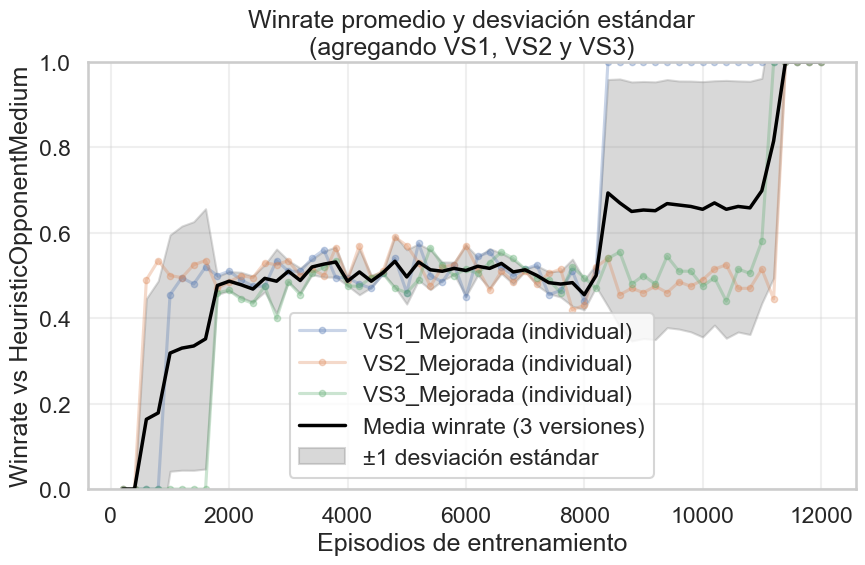

In [250]:
registros = []

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]
    for p in hist:
        registros.append({
            "version": vs,
            "episodios": p["episodios"],
            "winrate": p["winrate"],
        })

df_curvas = pd.DataFrame(registros)
df_curvas.head()

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

plt.figure(figsize=(9,6))

# Curvas individuales (semi transparentes)
for vs, sub in df_curvas.groupby("version"):
    plt.plot(sub["episodios"], sub["winrate"], ".-", alpha=0.3, label=f"{vs} (individual)")

# Media y desviación estándar
plt.plot(stats_win["episodios"], stats_win["mean"],
         color="black", linewidth=2.5, label="Media winrate (3 versiones)")

upper = stats_win["mean"] + stats_win["std"]
lower = stats_win["mean"] - stats_win["std"]

plt.fill_between(stats_win["episodios"], lower, upper,
                 color="gray", alpha=0.3, label="±1 desviación estándar")

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Winrate promedio y desviación estándar\n(agregando VS1, VS2 y VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Los resultados agregados de las tres versiones del agente muestran un patrón de aprendizaje claro y consistente tanto en el reward como en la longitud promedio de las partidas. En la primera gráfica se observa que, durante los primeros episodios, el reward se mantiene cercano a –1, lo que indica derrotas constantes en las etapas iniciales del entrenamiento. Sin embargo, alrededor del episodio 3000 se produce una mejora abrupta y sincronizada en las tres versiones, seguida de una fase estable donde el reward converge alrededor de valores cercanos a 0. Esta estabilización es confirmada por la media y la banda de desviación estándar, que muestran variaciones muy controladas, sugiriendo que las tres políticas aprenden comportamientos estratégicos similares. 

La longitud promedio de las partidas exhibe un comportamiento oscilante pero coherente entre versiones. Al inicio las partidas son más cortas, pero a medida que el agente mejora, los episodios tienden a prolongarse de forma intermitente, lo que refleja juegos más disputados. La media suavizada y la desviación estándar reafirman que, aunque existe variabilidad natural en la longitud de las partidas, las tres versiones convergen hacia dinámicas de juego muy parecidas, validando la estabilidad y consistencia del proceso de aprendizaje del agente.

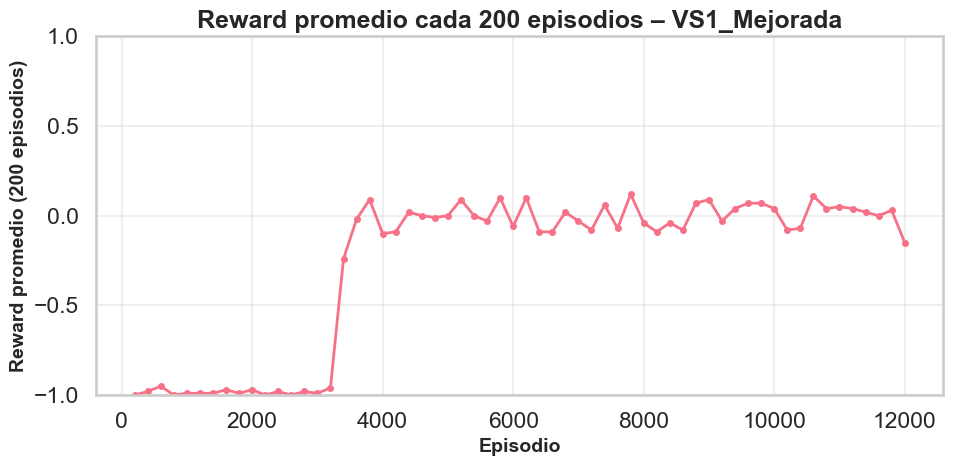

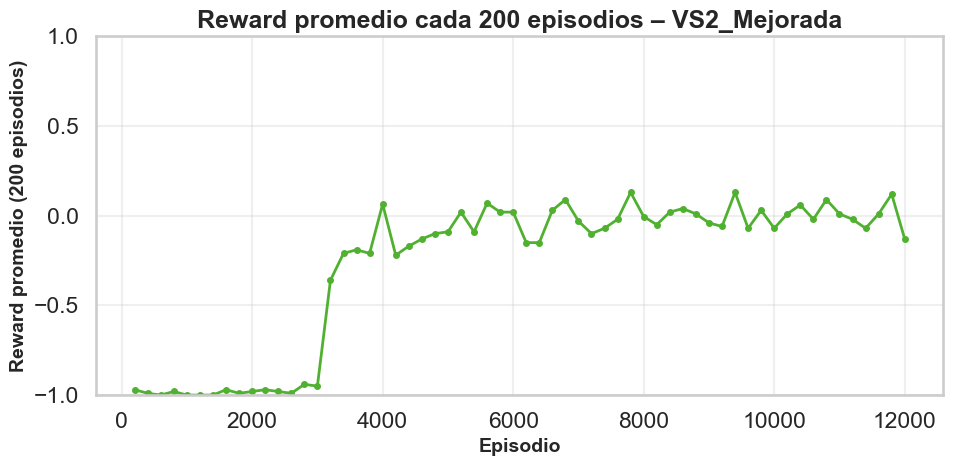

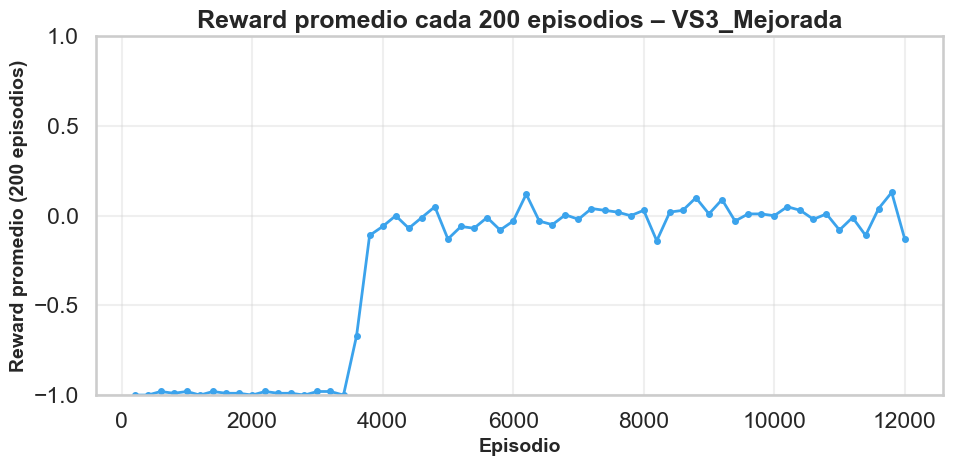

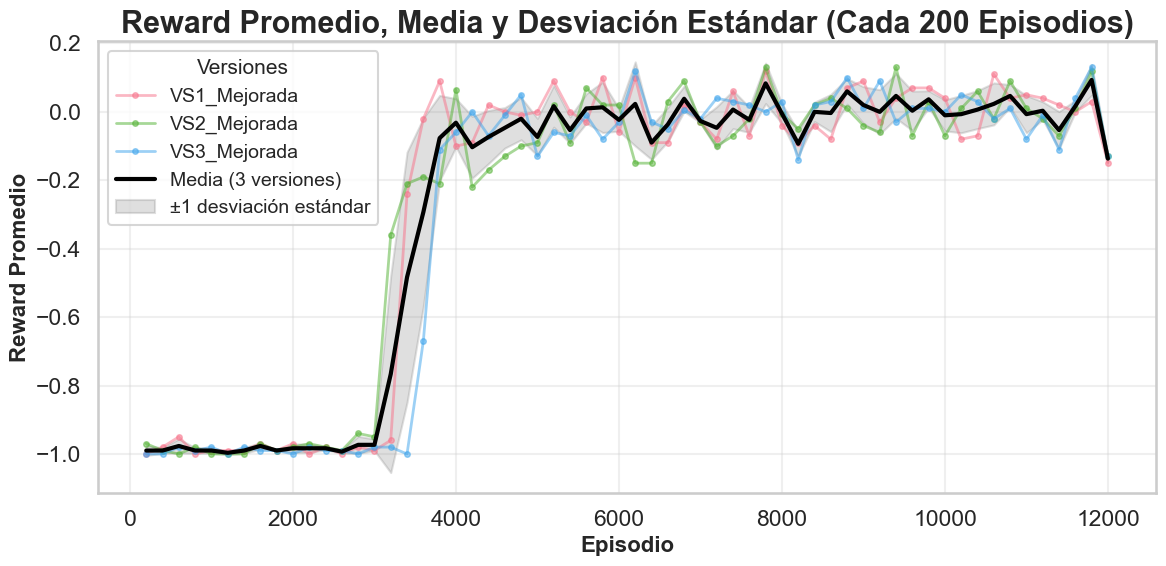

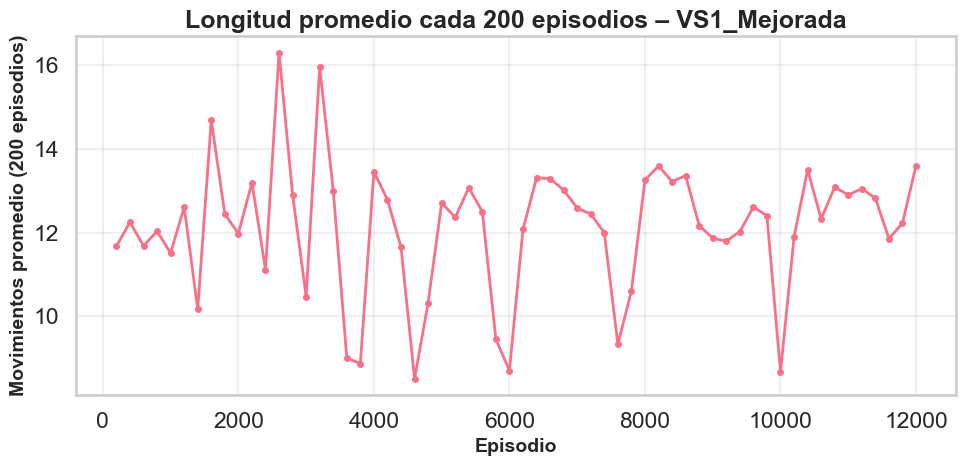

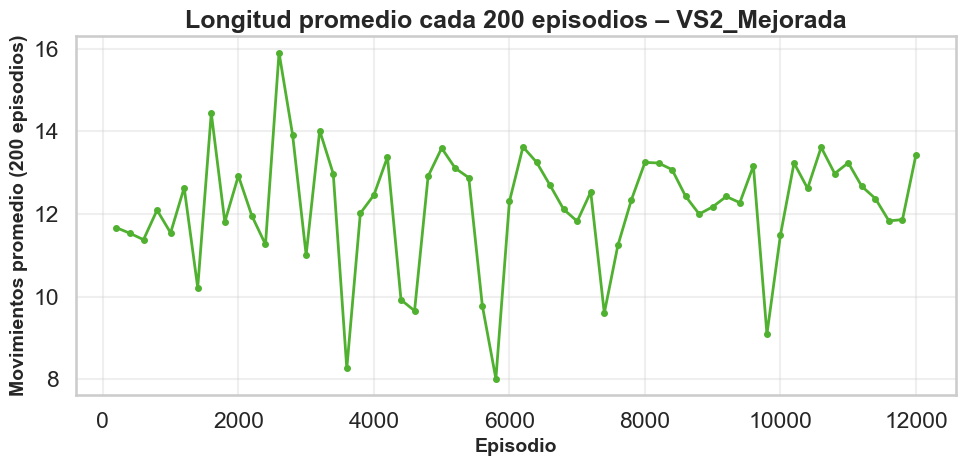

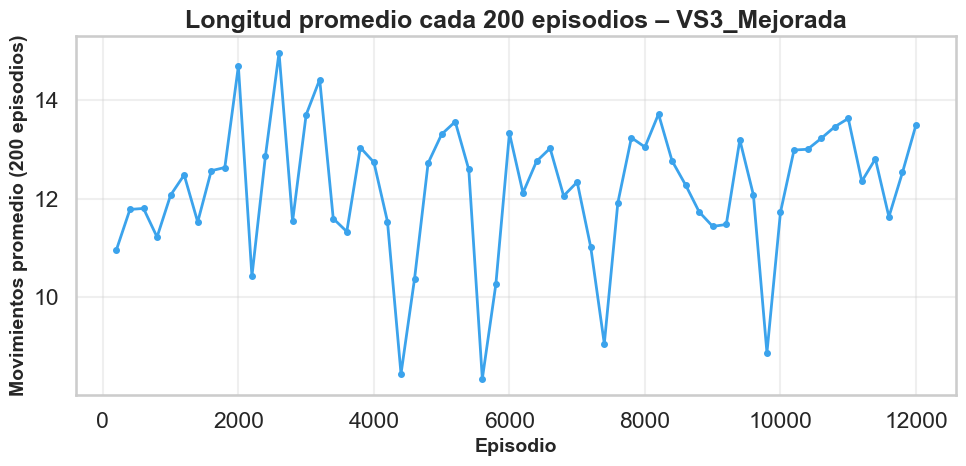

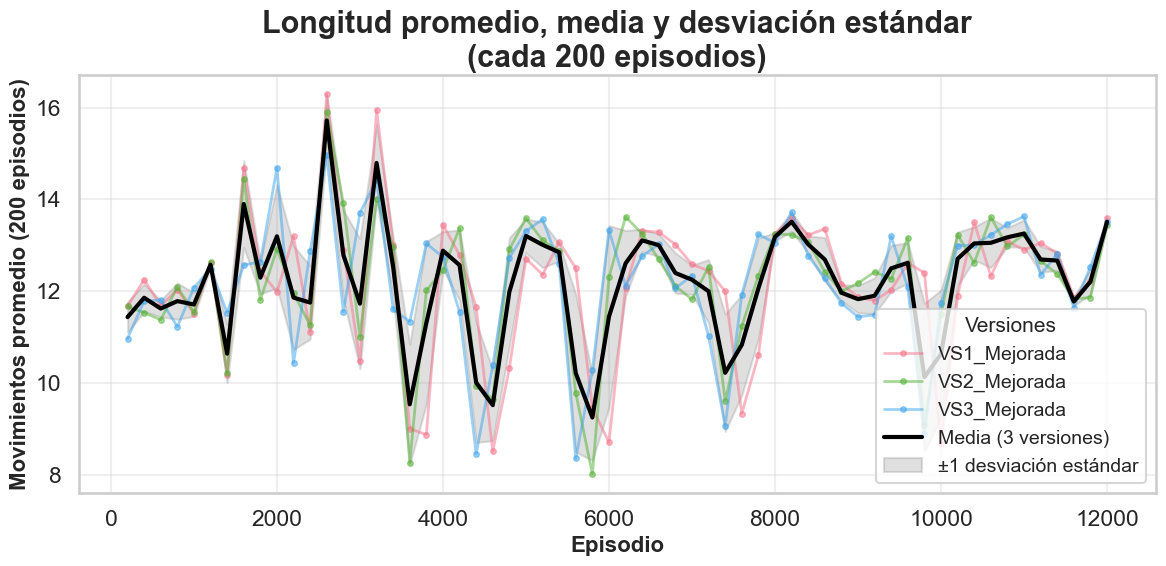

In [251]:
palette = sns.color_palette("husl", n_colors=len(selfplay_paths))
color_map = {vs: palette[i] for i, vs in enumerate(selfplay_paths.keys())}

def promedio_por_bloques(valores, episodios, tamaño_bloque=200):
    bloques_x = []
    bloques_y = []
    inicio = 0
    n = len(valores)

    while inicio < n:
        fin = min(inicio + tamaño_bloque, n)
        bloque = valores[inicio:fin]
        bloque_epi = episodios[inicio:fin]
        bloques_x.append(bloque_epi[-1])
        bloques_y.append(np.mean(bloque))
        inicio = fin

    return bloques_x, bloques_y

# REWARD PROMEDIADO CADA 200 EPISODIOS (HUSL)

for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    recompensas = data["recompensas"]

    x_avg, y_avg = promedio_por_bloques(recompensas, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(
        x_avg, y_avg,
        marker="o",
        markersize=4,
        linewidth=2,
        color=color_map[vs],
        label=f"{vs}"
    )

    plt.title(f"Reward promedio cada 200 episodios – {vs}", fontsize=18, fontweight="bold")
    plt.xlabel("Episodio", fontsize=14, fontweight="bold")
    plt.ylabel("Reward promedio (200 episodios)", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

    sns.set_theme(style="whitegrid", context="talk")

palette = sns.color_palette("husl", n_colors=len(selfplay_paths))
color_map = {vs: palette[i] for i, vs in enumerate(selfplay_paths.keys())}

# Construir matriz de curvas (para media y std)
all_x = None
all_y = []

for vs, path in selfplay_paths.items():
    data = cargar_json(path)
    episodios = np.array(data["episodios"])
    recompensas = np.array(data["recompensas"])

    # Promedio cada 200 episodios
    x_avg, y_avg = promedio_por_bloques(recompensas, episodios, tamaño_bloque=200)

    all_y.append(y_avg)
    if all_x is None:
        all_x = x_avg  # Todos los agentes comparten episodios similares

# Convertir lista a matriz
all_y = np.array(all_y)

media = np.mean(all_y, axis=0)
std   = np.std(all_y, axis=0)

plt.figure(figsize=(12, 6))

# Curvas individuales
for i, vs in enumerate(selfplay_paths.keys()):
    plt.plot(
        all_x, 
        all_y[i],
        marker="o",
        linewidth=2,
        markersize=4,
        alpha=0.5,
        color=color_map[vs],
        label=f"{vs}"
    )

# Media agregada
plt.plot(
    all_x,
    media,
    color="black",
    linewidth=3,
    label="Media (3 versiones)"
)

# Banda de desviación estándar
plt.fill_between(
    all_x,
    media - std,
    media + std,
    color="gray",
    alpha=0.25,
    label="±1 desviación estándar"
)

plt.title("Reward Promedio, Media y Desviación Estándar (Cada 200 Episodios)",
          fontsize=22, fontweight="bold")
plt.xlabel("Episodio", fontsize=16, fontweight="bold")
plt.ylabel("Reward Promedio", fontsize=16, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(title="Versiones", fontsize=14, title_fontsize=15)
plt.tight_layout()
plt.show()


# LONGITUD PROMEDIADA CADA 200 EPISODIOS (HUSL)


for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    longitudes = data["longitudes"]

    x_avg, y_avg = promedio_por_bloques(longitudes, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(
        x_avg, y_avg,
        marker="o",
        markersize=4,
        linewidth=2,
        color=color_map[vs],
        label=f"{vs}"
    )

    plt.title(f"Longitud promedio cada 200 episodios – {vs}", fontsize=18, fontweight="bold")
    plt.xlabel("Episodio", fontsize=14, fontweight="bold")
    plt.ylabel("Movimientos promedio (200 episodios)", fontsize=14, fontweight="bold")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    sns.set_theme(style="whitegrid", context="talk")

palette = sns.color_palette("husl", n_colors=len(selfplay_paths))
color_map = {vs: palette[i] for i, vs in enumerate(selfplay_paths.keys())}

all_x = None
all_y = []

for vs, path in selfplay_paths.items():
    data = cargar_json(path)
    episodios = np.array(data["episodios"])
    longitudes = np.array(data["longitudes"])

    x_avg, y_avg = promedio_por_bloques(longitudes, episodios, tamaño_bloque=200)

    all_y.append(y_avg)
    if all_x is None:
        all_x = x_avg

all_y = np.array(all_y)

media = np.mean(all_y, axis=0)
std   = np.std(all_y, axis=0)

plt.figure(figsize=(12, 6))

for i, vs in enumerate(selfplay_paths.keys()):
    plt.plot(
        all_x,
        all_y[i],
        marker="o",
        linewidth=2,
        markersize=4,
        alpha=0.5,
        color=color_map[vs],
        label=f"{vs}"
    )

plt.plot(
    all_x,
    media,
    color="black",
    linewidth=3,
    label="Media (3 versiones)"
)

plt.fill_between(
    all_x,
    media - std,
    media + std,
    color="gray",
    alpha=0.25,
    label="±1 desviación estándar"
)

plt.title(
    "Longitud promedio, media y desviación estándar\n(cada 200 episodios)",
    fontsize=22,
    fontweight="bold"
)
plt.xlabel("Episodio", fontsize=16, fontweight="bold")
plt.ylabel("Movimientos promedio (200 episodios)", fontsize=16, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend(title="Versiones", fontsize=14, title_fontsize=15)
plt.tight_layout()
plt.show()





En las tres versiones del agente se observa un comportamiento muy similar en los valores Q promedio por columna. En todas las gráficas, los valores se mantienen dentro de un rango estrecho y predominantemente negativo, alrededor de –0.10 a 0.02, indicando que el agente evalúa la mayoría de acciones iniciales como relativamente poco ventajosas en promedio. Ninguna versión muestra columnas con valores marcadamente positivos, por lo que no existe un sesgo fuerte hacia alguna acción específica. Esto sugiere que, aunque cada agente aprende de manera independiente, sus políticas convergen hacia evaluaciones muy parecidas del espacio de acciones. La única columna diferente es la 3, la cual presenta valores positivos, ya que se encuentra cerca del centro del tablero, una zona que suele ofrecer mayor flexibilidad estratégica en Connect4.

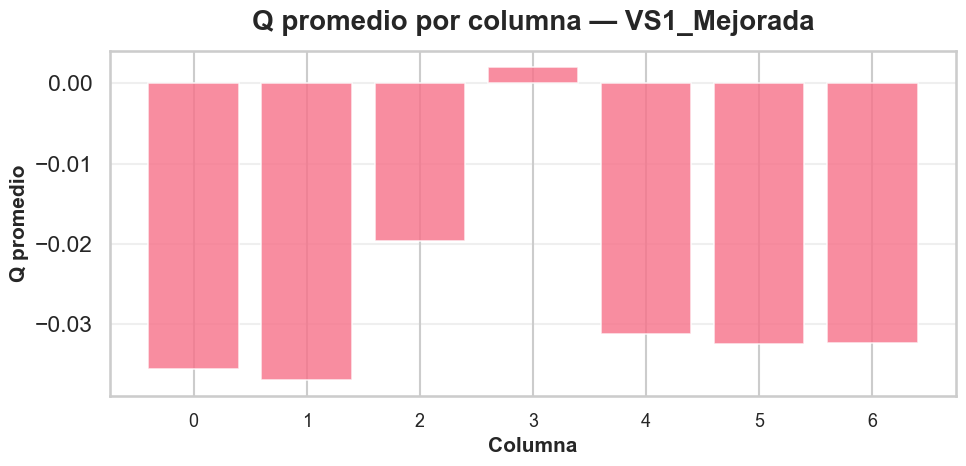

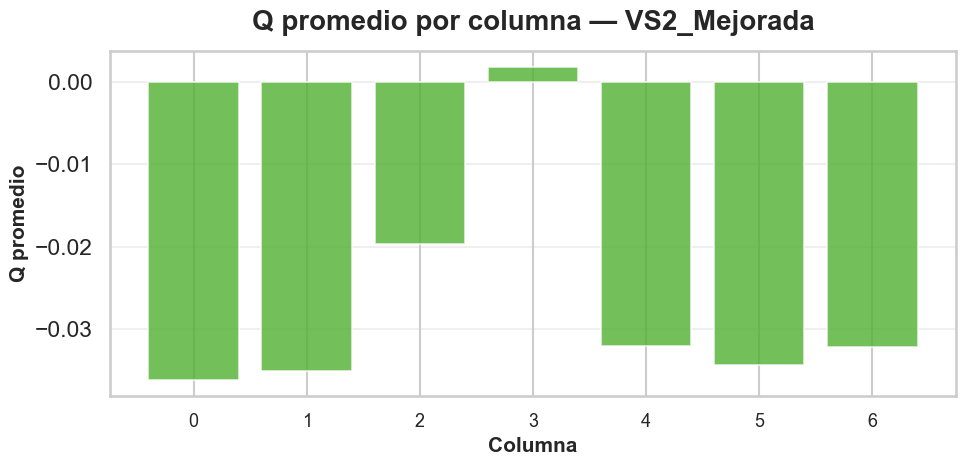

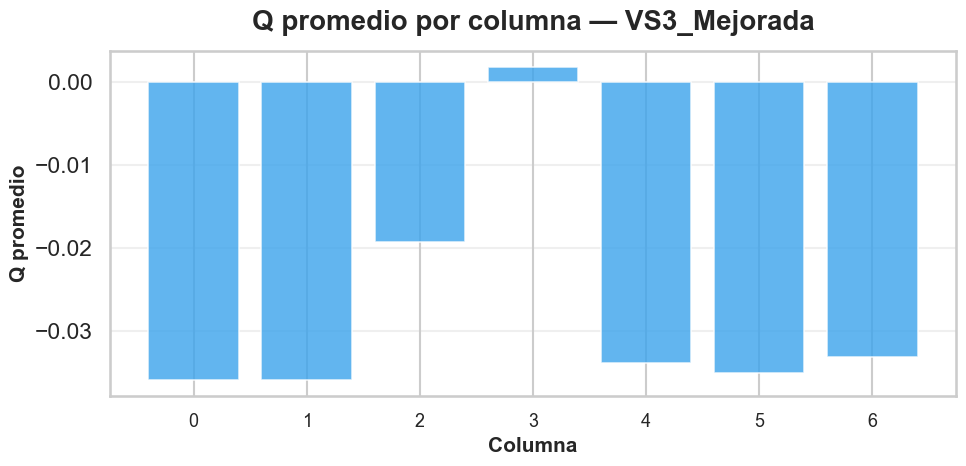

In [252]:
sns.set_theme(style="whitegrid", context="talk")

palette = sns.color_palette("husl", n_colors=len(qstats_paths))

for i, (vs, path) in enumerate(qstats_paths.items()):
    data = cargar_json(path)

    Q_por_col = {col: [] for col in range(7)}

    for estado, acciones in data.items():
        for a_str, info in acciones.items():
            col = int(a_str)
            Q_por_col[col].append(info["Q"])

    promedios = [np.mean(Q_por_col[c]) for c in range(7)]

    plt.figure(figsize=(10, 5))
    
    plt.bar(
        range(7),
        promedios,
        color=palette[i],
        linewidth=1.2,
        alpha=0.8
    )

    plt.title(f"Q promedio por columna — {vs}", fontsize=20, fontweight="bold", pad=15)
    plt.xlabel("Columna", fontsize=15, fontweight="bold")
    plt.ylabel("Q promedio", fontsize=15, fontweight="bold")
    plt.grid(True, axis="y", alpha=0.3)
    plt.xticks(range(7), fontsize=13)
    plt.tight_layout()
    plt.show()


### **3.2. Gradescope**

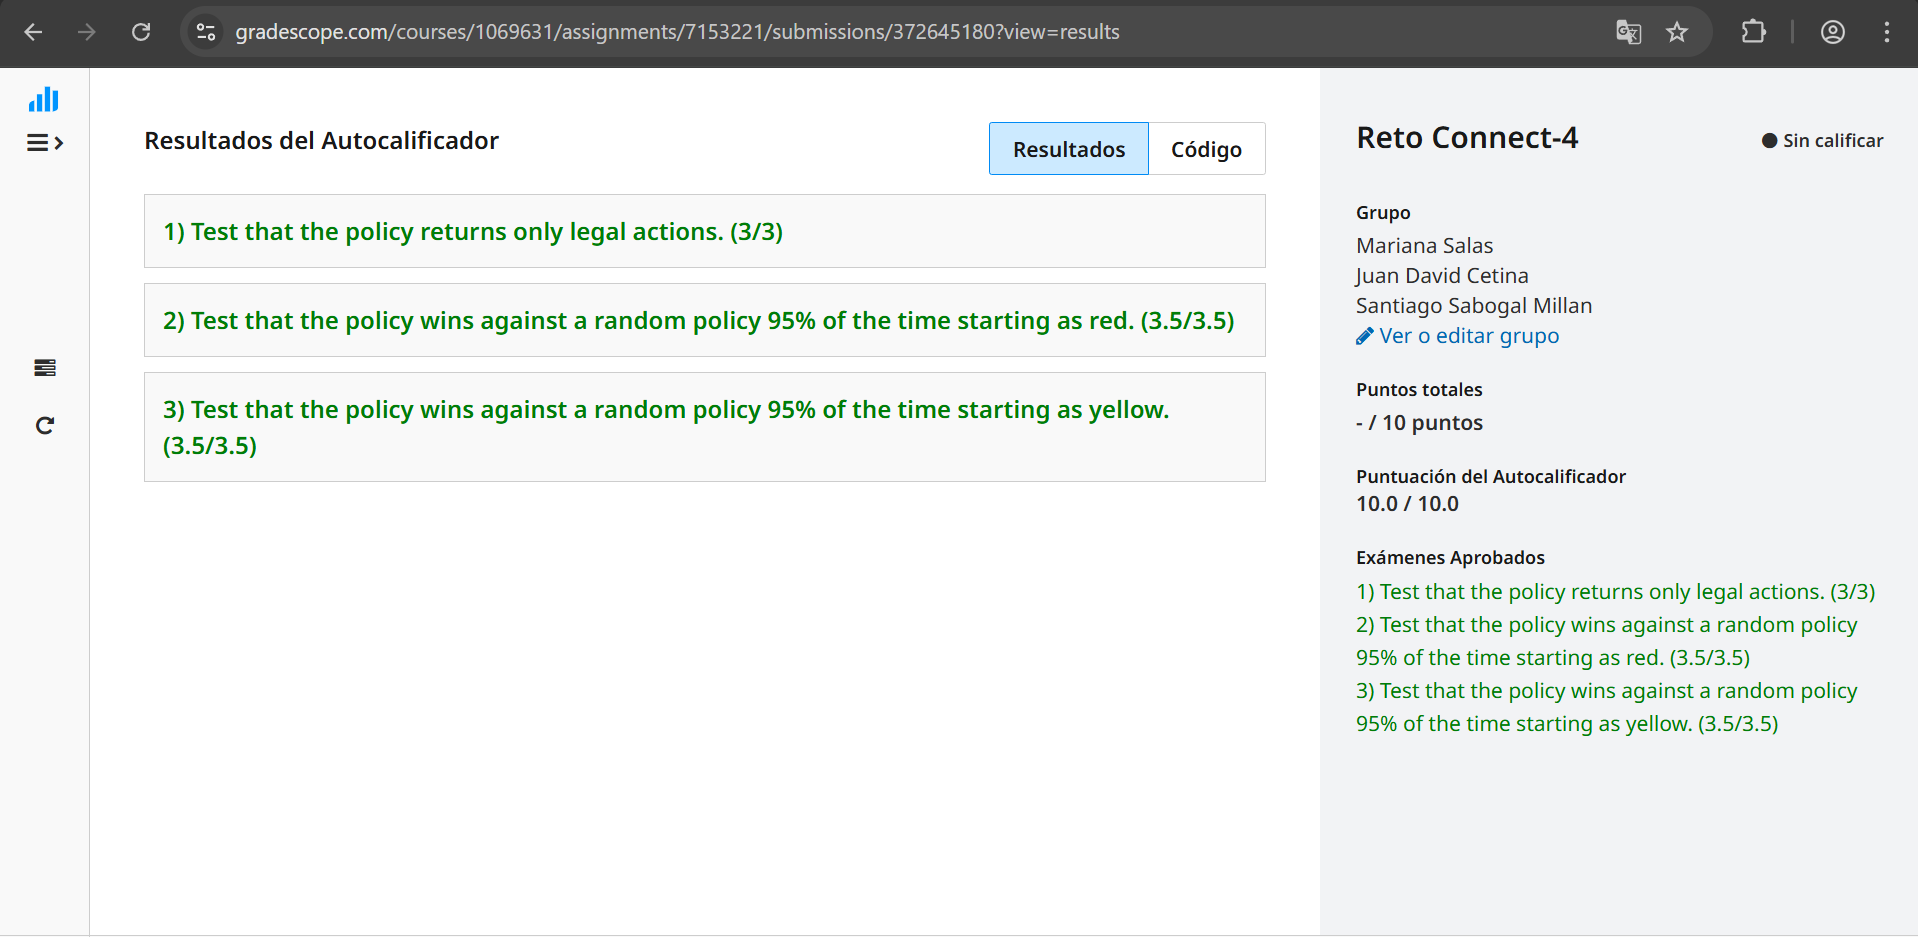

In [253]:
Image(filename="Gradescope.png")

## **4. Optimización del Agente**

Medida propia...

Pasar de heurístico a algo que mejora

In [254]:
versiones = ["VS1", "VS2", "VS3"]

curva_paths = {}
selfplay_paths = {}
qstats_paths = {}

for vs in versiones:
    curva_files = glob.glob(os.path.join(vs, "curva_vs_heuristic_medium_*.json"))
    selfplay_files = glob.glob(os.path.join(vs, "selfplay_qlearning_vs_heuristic_medium_*.json"))
    qstats_files = glob.glob(os.path.join(vs, "qstats_completo_*.json"))

    if not curva_files:
        print(f"[WARN] No encontré curva en {vs}")
        continue
    if not selfplay_files:
        print(f"[WARN] No encontré selfplay en {vs}")
        continue

    if not qstats_files:
        print(f"[WARN] No encontré qstats en {vs}")
        continue

    curva_paths[vs] = sorted(curva_files)[0]
    selfplay_paths[vs] = sorted(selfplay_files)[0]
    qstats_paths[vs] = sorted(qstats_files)[0]

curva_paths, selfplay_paths, qstats_paths

({'VS1': 'VS1\\curva_vs_heuristic_medium_20251123_003402.json',
  'VS2': 'VS2\\curva_vs_heuristic_medium_20251122_234525.json',
  'VS3': 'VS3\\curva_vs_heuristic_medium_20251122_234938.json'},
 {'VS1': 'VS1\\selfplay_qlearning_vs_heuristic_medium_20251123_003402.json',
  'VS2': 'VS2\\selfplay_qlearning_vs_heuristic_medium_20251122_234525.json',
  'VS3': 'VS3\\selfplay_qlearning_vs_heuristic_medium_20251122_234938.json'},
 {'VS1': 'VS1\\qstats_completo_20251123_003402.json',
  'VS2': 'VS2\\qstats_completo_20251122_234525.json',
  'VS3': 'VS3\\qstats_completo_20251122_234938.json'})

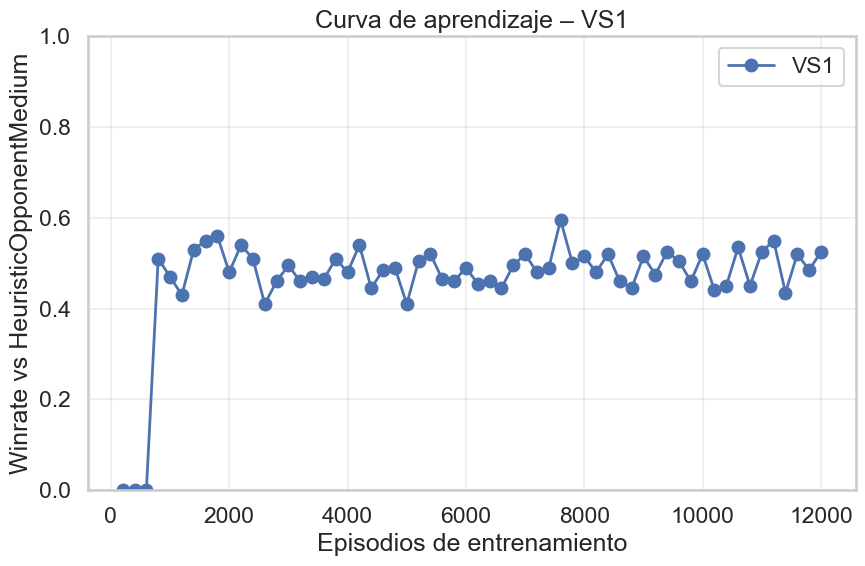

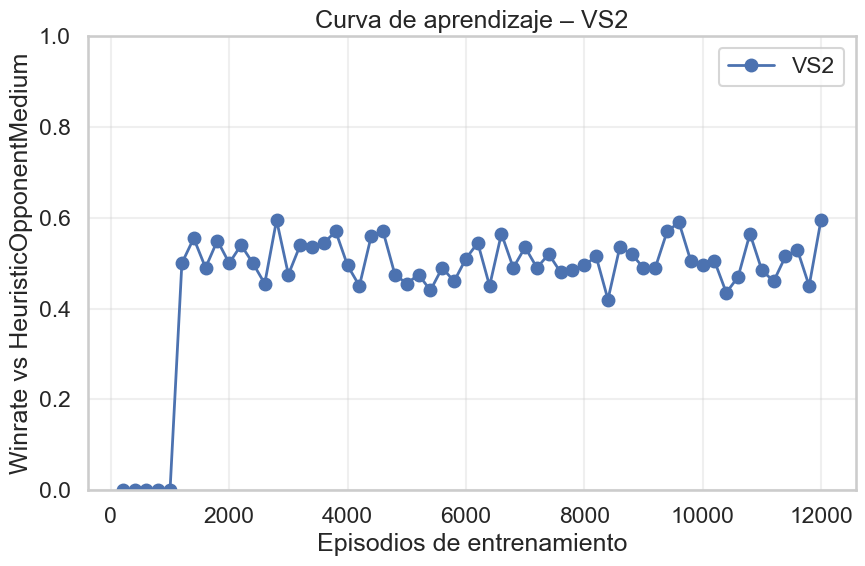

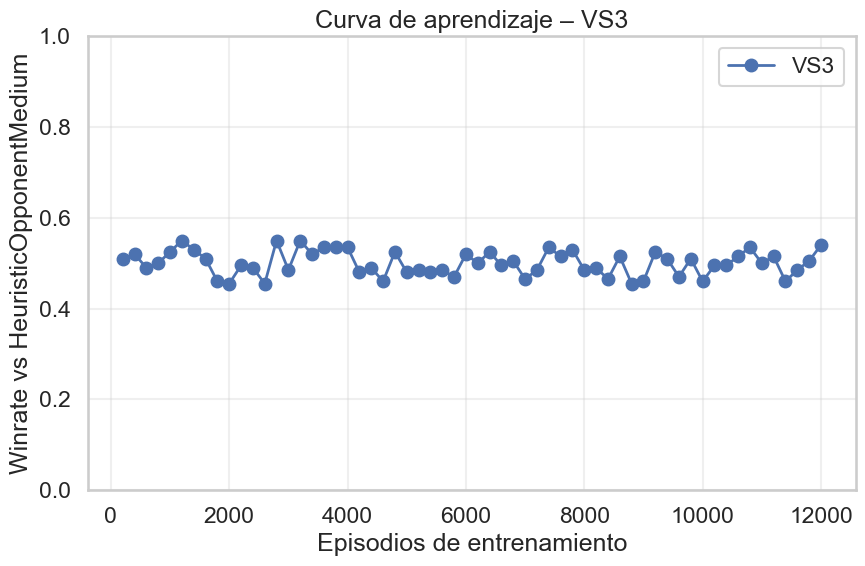

In [255]:
for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]

    episodios = [p["episodios"] for p in hist]
    winrates  = [p["winrate"] for p in hist]

    plt.figure(figsize=(9,6))
    plt.plot(episodios, winrates, marker="o", linewidth=2, label=f"{vs}")
    
    plt.xlabel("Episodios de entrenamiento")
    plt.ylabel("Winrate vs HeuristicOpponentMedium")
    plt.title(f"Curva de aprendizaje – {vs}")
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


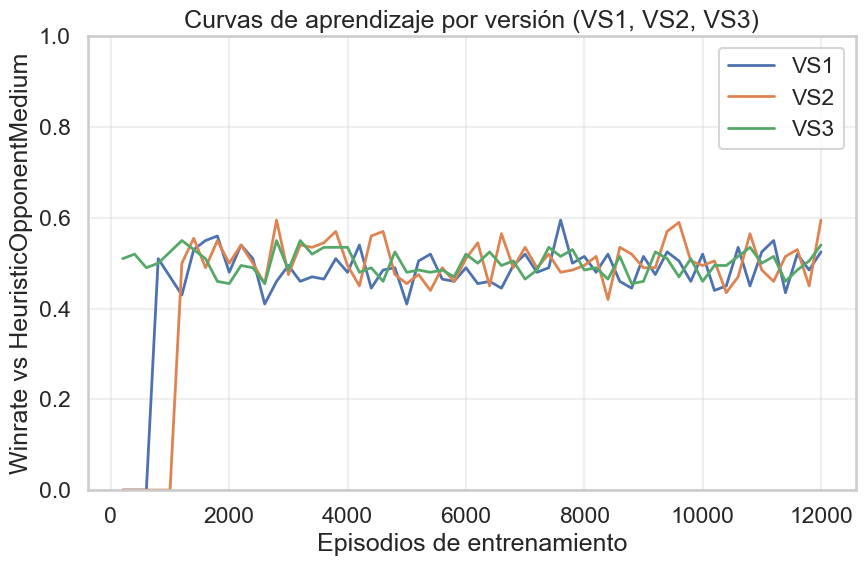

In [256]:
plt.figure(figsize=(9,6))

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]                  # lista de puntos {episodios, winrate, ...}
    episodios = [p["episodios"] for p in hist]
    winrates  = [p["winrate"] for p in hist]

    plt.plot(episodios, winrates, linewidth=2, label=vs)

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Curvas de aprendizaje por versión (VS1, VS2, VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [257]:
registros = []

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]
    for p in hist:
        registros.append({
            "version": vs,
            "episodios": p["episodios"],
            "winrate": p["winrate"],
        })

df_curvas = pd.DataFrame(registros)
df_curvas.head()

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

,episodios,mean,std
0,200,0.170000,0.294449
1,400,0.173333,0.300222
2,600,0.163333,0.282902
3,800,0.336667,0.291605
4,1000,0.331667,0.288545
5,1200,0.493333,0.060277
6,1400,0.538333,0.014434
7,1600,0.516667,0.030551
8,1800,0.523333,0.055076
9,2000,0.478333,0.022546


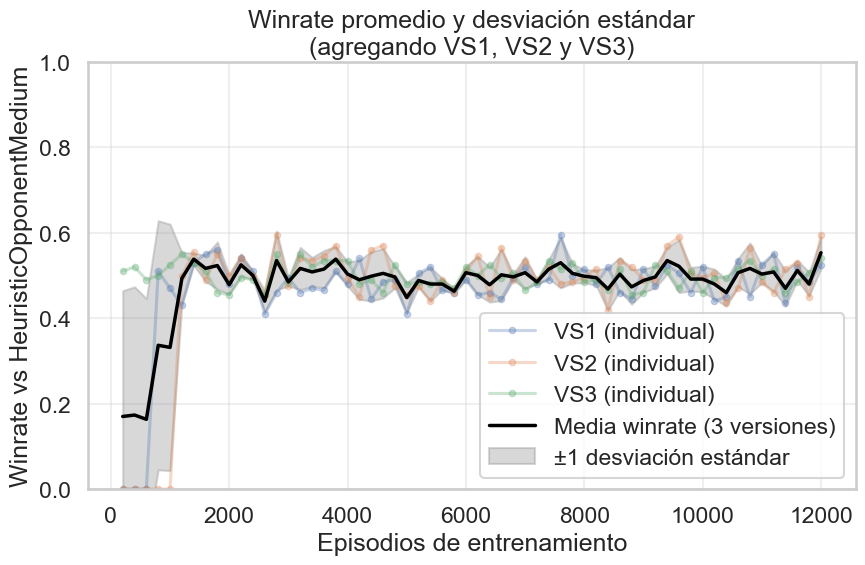

In [258]:
plt.figure(figsize=(9,6))

# Curvas individuales (semi transparentes)
for vs, sub in df_curvas.groupby("version"):
    plt.plot(sub["episodios"], sub["winrate"], ".-", alpha=0.3, label=f"{vs} (individual)")

# Media y desviación estándar
plt.plot(stats_win["episodios"], stats_win["mean"],
         color="black", linewidth=2.5, label="Media winrate (3 versiones)")

upper = stats_win["mean"] + stats_win["std"]
lower = stats_win["mean"] - stats_win["std"]

plt.fill_between(stats_win["episodios"], lower, upper,
                 color="gray", alpha=0.3, label="±1 desviación estándar")

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Winrate promedio y desviación estándar\n(agregando VS1, VS2 y VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

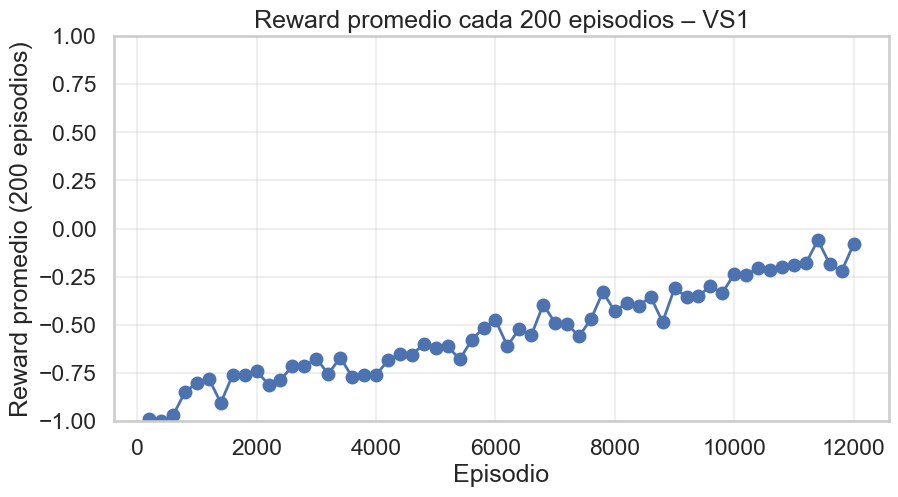

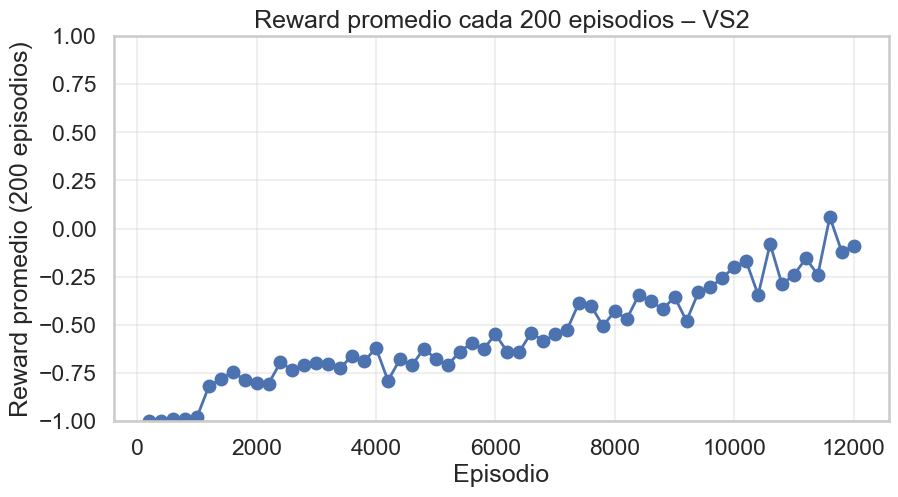

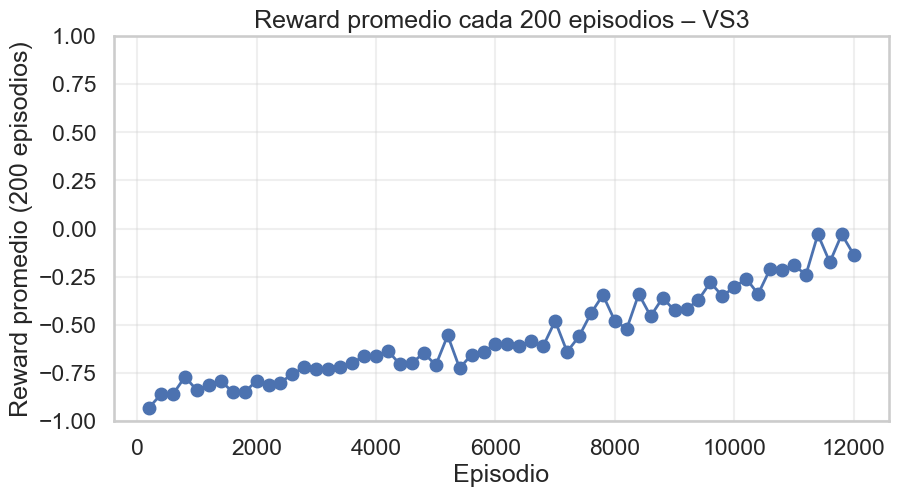

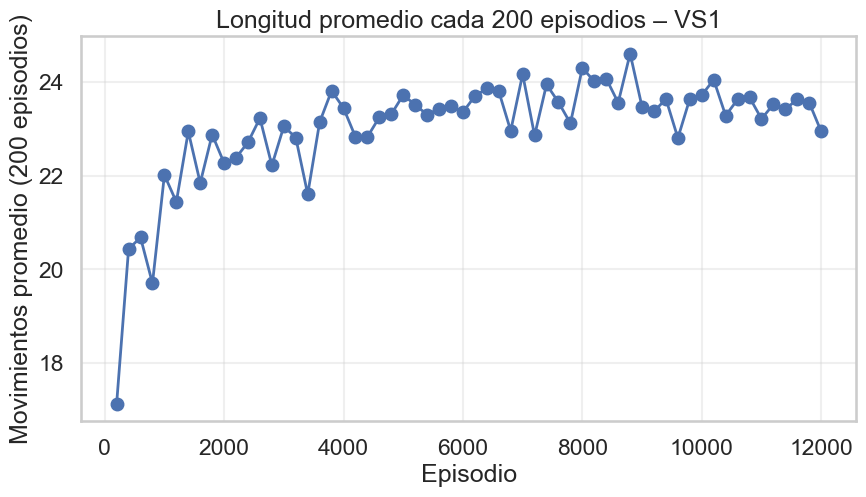

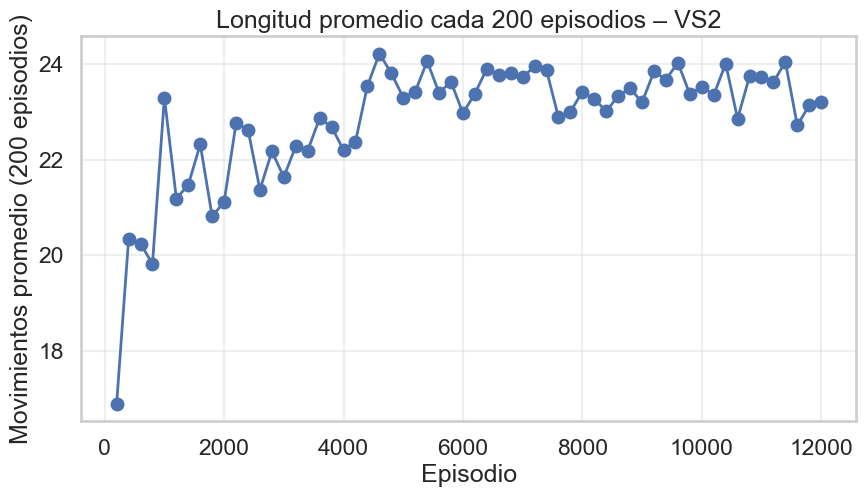

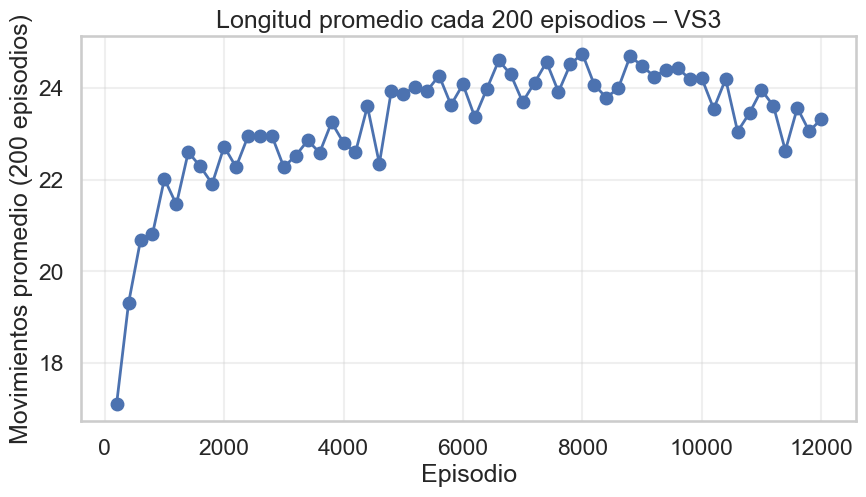

In [259]:
def promedio_por_bloques(valores, episodios, tamaño_bloque=200):
    """Promedia valores cada 'tamaño_bloque' episodios."""
    bloques_x = []
    bloques_y = []

    inicio = 0
    n = len(valores)

    while inicio < n:
        fin = min(inicio + tamaño_bloque, n)
        bloque = valores[inicio:fin]
        bloque_epi = episodios[inicio:fin]

        bloques_x.append(bloque_epi[-1])  # último episodio del bloque
        bloques_y.append(np.mean(bloque))

        inicio = fin

    return bloques_x, bloques_y


# -------------------------------------------------------------------
# GRAFICAR REWARD PROMEDIADO CADA 200 EPISODIOS PARA CADA VS
# -------------------------------------------------------------------
for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    recompensas = data["recompensas"]

    x_avg, y_avg = promedio_por_bloques(recompensas, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(x_avg, y_avg, marker="o", linewidth=2, label=f"{vs}")
    plt.title(f"Reward promedio cada 200 episodios – {vs}")
    plt.xlabel("Episodio")
    plt.ylabel("Reward promedio (200 episodios)")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.show()



# -------------------------------------------------------------------
# GRAFICAR LONGITUD PROMEDIADA CADA 200 EPISODIOS PARA CADA VS
# -------------------------------------------------------------------
for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    longitudes = data["longitudes"]

    x_avg, y_avg = promedio_por_bloques(longitudes, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(x_avg, y_avg, marker="o", linewidth=2, label=f"{vs}")
    plt.title(f"Longitud promedio cada 200 episodios – {vs}")
    plt.xlabel("Episodio")
    plt.ylabel("Movimientos promedio (200 episodios)")
    plt.grid(True, alpha=0.3)
    plt.show()


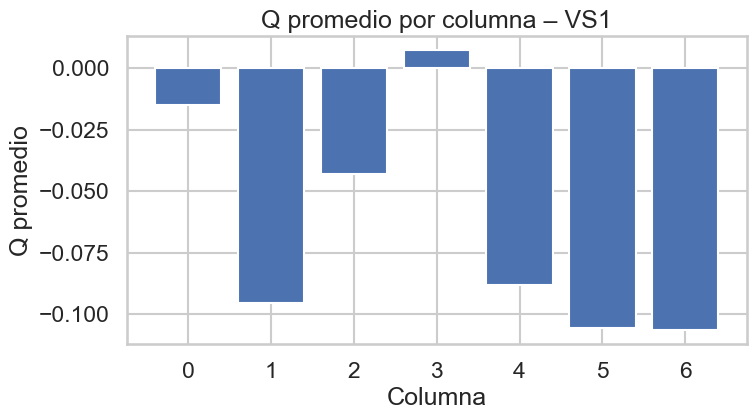

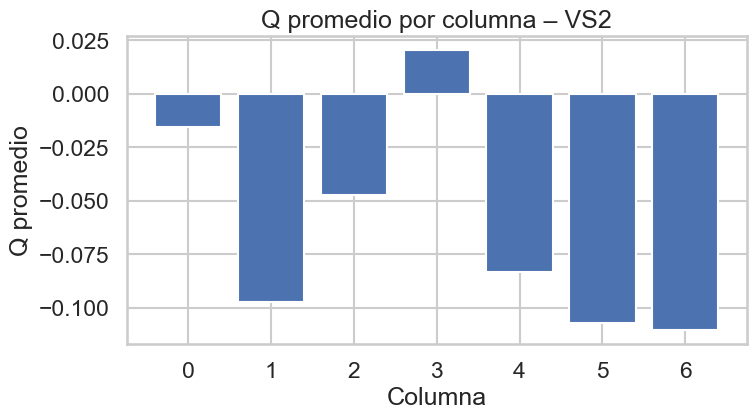

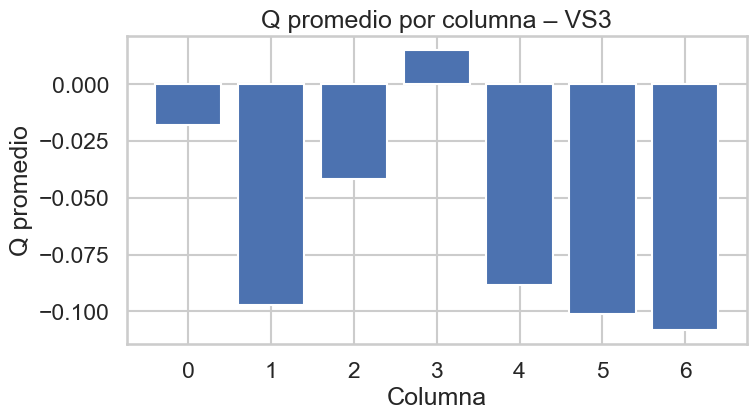

In [260]:
for vs, path in qstats_paths.items():
    data = cargar_json(path)

    Q_por_col = {col: [] for col in range(7)}

    for estado, acciones in data.items():
        for a_str, info in acciones.items():
            col = int(a_str)
            Q_por_col[col].append(info["Q"])

    promedios = [np.mean(Q_por_col[c]) for c in range(7)]

    plt.figure(figsize=(8,4))
    plt.bar(range(7), promedios)
    plt.title(f"Q promedio por columna – {vs}")
    plt.xlabel("Columna")
    plt.ylabel("Q promedio")
    plt.grid(True, axis="y")
    plt.show()


## **5. Reflexión y Análisis**

### **5.1. Limitaciones**

### **5.2. Mejoras**